In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Aquisição de Dados

In [2]:
df = yf.download(['BPAC3.SA', 'PETR4.SA', 'OIBR3.SA', 'ITUB4.SA', 'BBDC4.SA'])['Close']

[*********************100%***********************]  5 of 5 completed


In [3]:
df.head()

,BBDC4.SA,BPAC3.SA,ITUB4.SA,OIBR3.SA,PETR4.SA
Date,,,,,
2000-01-03,NaN,NaN,NaN,NaN,5.875
2000-01-04,NaN,NaN,NaN,NaN,5.550
2000-01-05,NaN,NaN,NaN,NaN,5.494
2000-01-06,NaN,NaN,NaN,NaN,5.475
2000-01-07,NaN,NaN,NaN,NaN,5.500


In [4]:
retornos = df.pct_change().loc['2018-01-01':]

In [5]:
retornos.head()

,BBDC4.SA,BPAC3.SA,ITUB4.SA,OIBR3.SA,PETR4.SA
Date,,,,,
2018-01-02,0.022157,0.091245,0.030528,-0.008265,0.027950
2018-01-03,0.004048,0.000000,0.006837,-0.027778,0.009064
2018-01-04,0.016407,0.000000,0.020826,-0.005712,0.001796
2018-01-05,0.005664,-0.028249,0.002880,0.005745,0.005977
2018-01-08,-0.000283,0.000000,-0.003316,-0.011428,0.011884


## Clusterização

### Normalização dos dados

In [6]:
from sklearn.preprocessing import normalize

retornos_normalizados = normalize(retornos)
retornos_normalizados = pd.DataFrame(retornos_normalizados, columns=retornos.columns)

retornos_normalizados.head()

,BBDC4.SA,BPAC3.SA,ITUB4.SA,OIBR3.SA,PETR4.SA
0,0.215229,0.886330,0.296543,-0.080282,0.271500
1,0.133676,0.000000,0.225786,-0.917365,0.299321
2,0.603632,0.000000,0.766222,-0.210154,0.066089
3,0.188047,-0.937934,0.095632,0.190746,0.198464
4,-0.016798,0.000000,-0.197172,-0.679446,0.706537


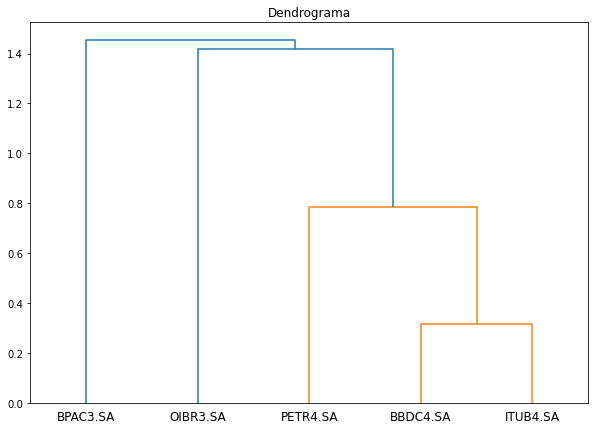

In [19]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Dendrograma")

clusters = shc.linkage(retornos.T, method='ward', metric='euclidean')

dend = shc.dendrogram(clusters, labels=retornos.columns)

### Reodernando dataframe de retornos

In [8]:
retornos.iloc[:,dend['leaves']]

,OIBR3.SA,BPAC3.SA,PETR4.SA,BBDC4.SA,ITUB4.SA
Date,,,,,
2018-01-02,-0.008265,0.091245,0.027950,0.022157,0.030528
2018-01-03,-0.027778,0.000000,0.009064,0.004048,0.006837
2018-01-04,-0.005712,0.000000,0.001796,0.016407,0.020826
2018-01-05,0.005745,-0.028249,0.005977,0.005664,0.002880
2018-01-08,-0.011428,0.000000,0.011884,-0.000283,-0.003316
...,...,...,...,...,...
2020-10-05,0.017964,0.028803,0.053102,0.014257,0.010624
2020-10-06,0.000000,0.000254,-0.004993,-0.003514,0.001752
2020-10-07,-0.005882,-0.015013,-0.007025,-0.010579,-0.007433


## Matrix Seriation

<AxesSubplot:>

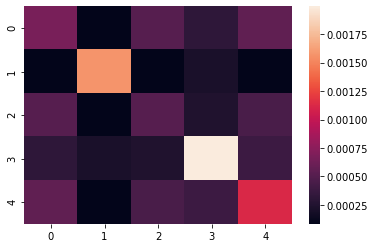

In [9]:
sns.heatmap(np.cov(retornos.T))

<AxesSubplot:>

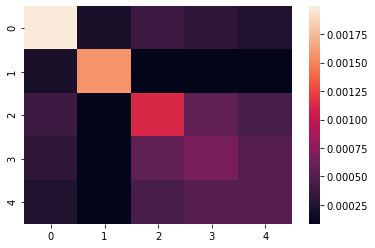

In [10]:
sns.heatmap(np.cov(retornos.iloc[:,dend['leaves']].T))

In [17]:
def compute_HRP_weights(covariances, res_order):
    # Inicialização de pesos
    pesos = pd.Series(1, index=res_order)
    clustered_alphas = [res_order]

    while len(clustered_alphas) > 0:
        # Instanciação de clusters do laço
        clustered_alphas = [cluster[start:end] for cluster in clustered_alphas
                            for start, end in ((0, len(cluster) // 2),
                                               (len(cluster) // 2, len(cluster)))
                            if len(cluster) > 1]

        # Iteração entre pares semelhantes
        for subcluster in range(0, len(clustered_alphas), 2):
            
            cluster_esquerdo = clustered_alphas[subcluster]
            cluster_direito = clustered_alphas[subcluster + 1]
            
            matriz_cov_esquerda = covariances[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal * (1 / np.sum(inversa_diagonal))
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = covariances[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal * (1 / np.sum(inversa_diagonal))
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            # Normalização dos clusters da iteração
            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

In [18]:
compute_HRP_weights(retornos.cov(), retornos.columns[dend['leaves']])

OIBR3.SA    0.158544
BPAC3.SA    0.201049
PETR4.SA    0.207996
BBDC4.SA    0.186993
ITUB4.SA    0.245419
dtype: float64